# Tile Coding
---

Tile coding is an innovative way of discretizing a continuous space that enables better generalization compared to a single grid-based approach. The fundamental idea is to create several overlapping grids or _tilings_; then for any given sample value, you need only check which tiles it lies in. You can then encode the original continuous value by a vector of integer indices or bits that identifies each activated tile.

### 1. Import the Necessary Packages

''' 
%%javascript
// IPython.OutputArea.prototype._should_scroll = function(lines) {
//     return false;
// }
'''

In [1]:
# Import common libraries
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's begin with an environment that has a continuous state space, but a discrete action space.

In [2]:
# Create an environment
env = gym.make('Acrobot-v1')
# env = TraceRecordingWrapper(env)
env.seed(505);

# Explore state (observation) space
print("State space:", env.observation_space)
print("- low:", env.observation_space.low)
print("- high:", env.observation_space.high)

# Explore action space
print("Action space:", env.action_space)

State space: Box(-28.274333953857422, 28.274333953857422, (6,), float32)
- low: [ -1.     -1.     -1.     -1.    -12.566 -28.274]
- high: [ 1.     1.     1.     1.    12.566 28.274]
Action space: Discrete(3)


Note that the state space is multi-dimensional, with most dimensions ranging from -1 to 1 (positions of the two joints), while the final two dimensions have a larger range. How do we discretize such a space using tiles?

### 3. Tiling

Let's first design a way to create a single tiling for a given state space. This is very similar to a uniform grid! The only difference is that you should include an offset for each dimension that shifts the split points.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, `bins = (10, 10)`, and `offsets = (-0.1, 0.5)`, then return a list of 2 NumPy arrays (2 dimensions) each containing the following split points (9 split points per dimension):

```
[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]
```

Notice how the split points for the first dimension are offset by `-0.1`, and for the second dimension are offset by `+0.5`. This might mean that some of our tiles, especially along the perimeter, are partially outside the valid state space, but that is unavoidable and harmless.

In [3]:
def create_tiling_grid(low, high, bins=(10, 10), offsets=(0.0, 0.0)):
    """Define a uniformly-spaced grid that can be used for tile-coding a space.
    
    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins or tiles along each corresponding dimension.
    offsets : tuple
        Split points for each dimension should be offset by these values.
    
    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    # TODO: Implement this
    grid= [np.linspace(l+(h-l)/(bins[i]),h,bins[i]-1,endpoint=False)+o for i,(l,h,o) in enumerate(zip(low, high,offsets))]
    print("Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>")
    for l, h, b, o, splits in zip(low, high, bins, offsets, grid):
        print("    [{}, {}] / {} + ({}) => {}".format(l, h, b, o, splits))
    return grid

#Expanding above command    
#     for i,(l,h,o) in enumerate(zip(low, high,offsets)):
#         print('l',l,'h',h)
#         diff=(h-l)/(bins[i])
#         grid.append(np.linspace(l+diff,h,bins[i]-1,endpoint=False))
#         if i==1:
#             print('diff')
#             print('Original grid', grid)
#             print('o',o)
#         grid[-1]+=o
#         if i==1:
#             print('Final grid',grid)


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins=(10, 10), offsets=(-0.1, 0.5))  # [test]

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.1) => [-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7]
    [-5.0, 5.0] / 10 + (0.5) => [-3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]


[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]

You can now use this function to define a set of tilings that are a little offset from each other.

In [4]:
def create_tilings(low, high, tiling_specs):
    """Define multiple tilings using the provided specifications.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    tiling_specs : list of tuples
        A sequence of (bins, offsets) to be passed to create_tiling_grid().

    Returns
    -------
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    """
    # TODO: Implement this
    tilings=[create_tiling_grid(low, high, ts[0], ts[1]) for ts in tiling_specs]
    return tilings

# Tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.066) => [-0.866 -0.666 -0.466 -0.266 -0.066  0.134  0.334  0.534  0.734]
    [-5.0, 5.0] / 10 + (-0.33) => [-4.33 -3.33 -2.33 -1.33 -0.33  0.67  1.67  2.67  3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.066) => [-0.734 -0.534 -0.334 -0.134  0.066  0.266  0.466  0.666  0.866]
    [-5.0, 5.0] / 10 + (0.33) => [-3.67 -2.67 -1.67 -0.67  0.33  1.33  2.33  3.33  4.33]


[tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]

In [5]:
tilings

[[array([-0.866, -0.666, -0.466, -0.266, -0.066,  0.134,  0.334,  0.534,  0.734]),
  array([-4.33, -3.33, -2.33, -1.33, -0.33,  0.67,  1.67,  2.67,  3.67])],
 [array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
  array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])],
 [array([-0.734, -0.534, -0.334, -0.134,  0.066,  0.266,  0.466,  0.666,  0.866]),
  array([-3.67, -2.67, -1.67, -0.67,  0.33,  1.33,  2.33,  3.33,  4.33])]]

It may be hard to gauge whether you are getting desired results or not. So let's try to visualize these tilings.

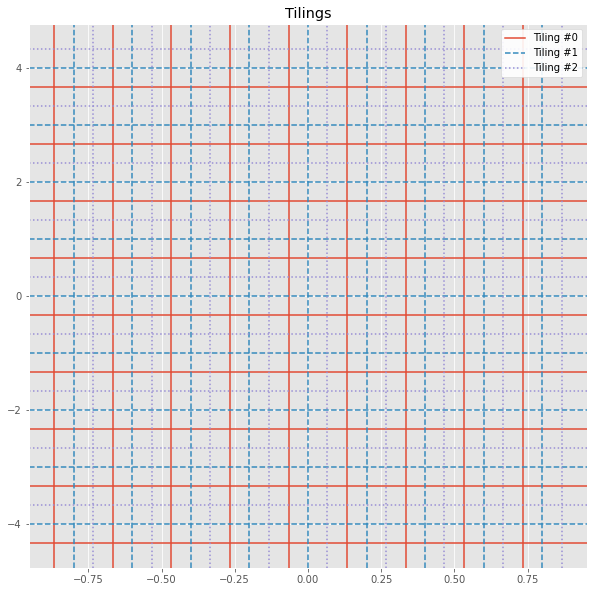

In [6]:
from matplotlib.lines import Line2D

def visualize_tilings(tilings):
    """Plot each tiling as a grid."""
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []

    fig, ax = plt.subplots(figsize=(10, 10))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x=x, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], label=i)
        for y in grid[1]:
            l = ax.axhline(y=y, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ["Tiling #{}".format(t) for t in range(len(legend_lines))], facecolor='white', framealpha=0.9)
    ax.set_title("Tilings")
    return ax  # return Axis object to draw on later, if needed


visualize_tilings(tilings);

Great! Now that we have a way to generate these tilings, we can next write our encoding function that will convert any given continuous state value to a discrete vector.

### 4. Tile Encoding

Implement the following to produce a vector that contains the indices for each tile that the input state value belongs to. The shape of the vector can be the same as the arrangment of tiles you have, or it can be ultimately flattened for convenience.

You can use the same `discretize()` function here from grid-based discretization, and simply call it for each tiling.

In [7]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    
    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    # TODO: Implement this
    return tuple([np.digitize(s,g) for s,g in zip(sample,grid)])
        


def tile_encode(sample, tilings, flatten=False):
    """Encode given sample using tile-coding.
    
    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    tilings : list
        A list of tilings (grids), each produced by create_tiling_grid().
    flatten : bool
        If true, flatten the resulting binary arrays into a single long vector.

    Returns
    -------
    encoded_sample : list or array_like
        A list of binary vectors, one for each tiling, or flattened into one.
    """
    # TODO: Implement this
    return [discretize(sample, tile) for tile in tilings]


# Test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = tuple([tile_encode(sample, tilings) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nEncoded samples:", repr(encoded_samples), sep="\n")


Samples:
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded samples:
([(0, 0), (0, 0), (0, 0)], [(1, 8), (1, 8), (0, 7)], [(2, 5), (2, 5), (2, 4)], [(6, 3), (6, 3), (5, 2)], [(6, 3), (5, 3), (5, 2)], [(9, 7), (8, 7), (8, 7)], [(8, 1), (8, 1), (8, 0)], [(9, 9), (9, 9), (9, 9)])


Note that we did not flatten the encoding above, which is why each sample's representation is a pair of indices for each tiling. This makes it easy to visualize it using the tilings.

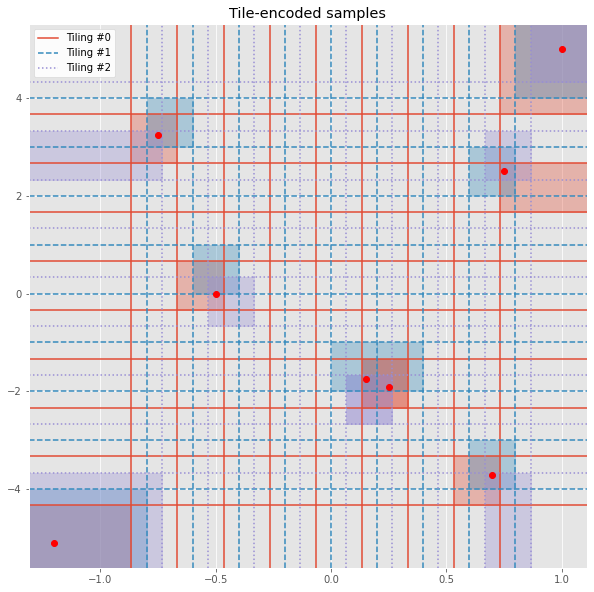

In [8]:
from matplotlib.patches import Rectangle

def visualize_encoded_samples(samples, encoded_samples, tilings, low=None, high=None):
    """Visualize samples by activating the respective tiles."""
    samples = np.array(samples)  # for ease of indexing

    # Show tiling grids
    ax = visualize_tilings(tilings)
    
    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(samples[:, 0], samples[:, 1], 'o', alpha=0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]

    # Map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = [np.hstack((np.array([low]).T, grid, np.array([high]).T)) for grid in tilings]  # add low and high ends
    tile_centers = [(grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 for grid_extended in tilings_extended]  # compute center of each tile
    tile_toplefts = [grid_extended[:, :-1] for grid_extended in tilings_extended]  # compute topleft of each tile
    tile_bottomrights = [grid_extended[:, 1:] for grid_extended in tilings_extended]  # compute bottomright of each tile

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            # Shade the entire tile with a rectangle
            topleft = tile_toplefts[i][0][tile[0]], tile_toplefts[i][1][tile[1]]
            bottomright = tile_bottomrights[i][0][tile[0]], tile_bottomrights[i][1][tile[1]]
            ax.add_patch(Rectangle(topleft, bottomright[0] - topleft[0], bottomright[1] - topleft[1],
                                   color=colors[i], alpha=0.33))

            # In case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < topleft) or any(sample > bottomright):
                # So plot a point in the center of the tile and draw a connecting line
                cx, cy = tile_centers[i][0][tile[0]], tile_centers[i][1][tile[1]]
                ax.add_line(Line2D([sample[0], cx], [sample[1], cy], color=colors[i]))
                ax.plot(cx, cy, 's', color=colors[i])
    
    # Finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color='r')

    ax.margins(x=0, y=0)  # remove unnecessary margins
    ax.set_title("Tile-encoded samples")
    return ax

visualize_encoded_samples(samples, encoded_samples, tilings);

Inspect the results and make sure you understand how the corresponding tiles are being chosen. Note that some samples may have one or more tiles in common.

### 5. Q-Table with Tile Coding

The next step is to design a special Q-table that is able to utilize this tile coding scheme. It should have the same kind of interface as a regular table, i.e. given a `<state, action>` pair, it should return a `<value>`. Similarly, it should also allow you to update the `<value>` for a given `<state, action>` pair (note that this should update all the tiles that `<state>` belongs to).

The `<state>` supplied here is assumed to be from the original continuous state space, and `<action>` is discrete (and integer index). The Q-table should internally convert the `<state>` to its tile-coded representation when required.

In [9]:
class QTable:
    """Simple Q-table."""

    def __init__(self, state_size, action_size):
        """Initialize Q-table.
        
        Parameters
        ----------
        state_size : tuple
            Number of discrete values along each dimension of state space.
        action_size : int
            Number of discrete actions in action space.
        """
        self.state_size = state_size
        self.action_size = action_size

        # TODO: Create Q-table, initialize all Q-values to zero
        # Note: If state_size = (9, 9), action_size = 2, q_table.shape should be (9, 9, 2)
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("QTable(): size =", self.q_table.shape)


class TiledQTable:
    """Composite Q-table with an internal tile coding scheme."""
    
    def __init__(self, low, high, tiling_specs, action_size):
        """Create tilings and initialize internal Q-table(s).
        
        Parameters
        ----------
        low : array_like
            Lower bounds for each dimension of state space.
        high : array_like
            Upper bounds for each dimension of state space.
        tiling_specs : list of tuples
            A sequence of (bins, offsets) to be passed to create_tilings() along with low, high.
        action_size : int
            Number of discrete actions in action space.
        """
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits)+1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        self.q_table1 = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print("TiledQTable(): no. of internal tables = ", len(self.q_tables))

    
    def get(self, state, action):
        """Get Q-value for given <state, action> pair.
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        
        Returns
        -------
        value : float
            Q-value of given <state, action> pair, averaged from all internal Q-tables.
        """
        # TODO: Encode state to get tile indices
        tile_state=tile_encode(state, self.tilings)
        #Tile_state is a list of len x where x= number of tilings
        #self.q_tables is a list of x QTables where x = number of tilings with each QTable having the standard [state,action] dimensions
        #Now each element of the tile_state is mapped to a separate tiling grid in the self.q_tables. So we take each element
        #of each tile state, use that as the state keys and retrieve the action value as the third element of the key
        #to find each value
        #This will return an array of values (One value per state to grid mapping) which we average. Hence, below:
        a=[grid.q_table[tuple(new_state + (action,))] for new_state,grid in zip(tile_state,self.q_tables)]
        return(np.mean(a))

    def update(self, state, action, value, alpha=0.1):
        """Soft-update Q-value for given <state, action> pair to value.
        
        Instead of overwriting Q(state, action) with value, perform soft-update:
            Q(state, action) = alpha * value + (1.0 - alpha) * Q(state, action)
        
        Parameters
        ----------
        state : array_like
            Vector representing the state in the original continuous space.
        action : int
            Index of desired action.
        value : float
            Desired Q-value for <state, action> pair.
        alpha : float
            Update factor to perform soft-update, in [0.0, 1.0] range.
        """
        # TODO: Encode state to get tile indices
        
        tile_state=tile_encode(state, self.tilings)
#         print('Initial seed value',value)
        for new_state1,grid in zip(tile_state,self.q_tables):
            q_old= grid.q_table[tuple(new_state1 + (action,))]
            q_new=q_old*(1-alpha)+value*alpha
            grid.q_table[tuple(new_state1 + (action,))]=q_new
#             print(f'Value being updated is {q_new}')
#         for new_state1,grid in zip(tile_state,self.q_tables):
#             print('Revised values reflecting')
#             print(grid.q_table[tuple(new_state1 + (action,))])
        # TODO: Update q-value for each tiling by update factor alpha

# Test with a sample Q-table
tq = TiledQTable(low, high, tiling_specs, 2)
s1 = 3; s2 = 4; a = 0; q = 1.0
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value at sample = s1, action = a
print("[UPDATE] Q({}, {}) = {}".format(samples[s2], a, q)); tq.update(samples[s2], a, q)  # update value for sample with some common tile(s)
print("[GET]    Q({}, {}) = {}".format(samples[s1], a, tq.get(samples[s1], a)))  # check value again, should be slightly updated

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.066) => [-0.866 -0.666 -0.466 -0.266 -0.066  0.134  0.334  0.534  0.734]
    [-5.0, 5.0] / 10 + (-0.33) => [-4.33 -3.33 -2.33 -1.33 -0.33  0.67  1.67  2.67  3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.066) => [-0.734 -0.534 -0.334 -0.134  0.066  0.266  0.466  0.666  0.866]
    [-5.0, 5.0] / 10 + (0.33) => [-3.67 -2.67 -1.67 -0.67  0.33  1.33  2.33  3.33  4.33]
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
QTable(): size = (10, 10, 2)
TiledQTable(): no. of internal tables =  3
[GET]    Q((0.25, -1.9), 0) = 0.0
[UPDATE] Q((0.15, -1.75), 0) = 1.0
[GET]    Q((0

If you update the q-value for a particular state (say, `(0.25, -1.91)`) and action (say, `0`), then you should notice the q-value of a nearby state (e.g. `(0.15, -1.75)` and same action) has changed as well! This is how tile-coding is able to generalize values across the state space better than a single uniform grid.

### 6. Implement a Q-Learning Agent using Tile-Coding

Now it's your turn to apply this discretization technique to design and test a complete learning agent! 

In [10]:
from collections import defaultdict

In [11]:
class Agent():
    def __init__(self,tqt,action_n, alpha=0.02, gamma=0.99,epsilon=1):
        '''
        Arguments:
        alpha = learning rate
        gamma = discount factor
        epsilon = epsilon-greedy ratio
        switch - Binary - switch from more exploration to more exploitation at the end of the run()
        tqt - TiledQTable object to map states and extract info
        action_n = no. of actions available in the space
        '''
        self.alpha=alpha
        self.gamma=gamma
        self.epsilon=epsilon
        self.tqt=tqt
        self.policy=defaultdict(lambda:np.zeros(1))
        self.action_n=action_n
        self.switch1=True
        self.seed = np.random.seed(0)
        self.last_state=env.reset()
        self.last_action=np.random.randint(0,env.action_space.n)
        
#     def switch(self):
#             self.switch1=True
#             self.epsilon = 0.01 
#             self.alpha=0.4
#             self.gamma=0.6
        
#     def update_policy(self, state, enc_state):
#         vals=[self.get_Q(state,a) for a in range(env.action_space.n)]
#         self.policy[enc_state]=np.argmax([self.get_Q(state,a) for a in range(env.action_space.n)])
    
    def get_Q(self, state, action):
        return self.tqt.get(state, action)
      
    def get_action(self,state,env):
        if np.random.uniform(0,1)>=self.epsilon: #and enc_state in self.policy
            return np.argmax([self.tqt.get(state,a) for a in range(env.action_space.n)])
        else:
            return np.random.randint(0,env.action_space.n)
        
    def calc_value(self,state,action, reward, next_state, next_action):
        if not self.switch1:
            q=self.get_sarsa(state, action, reward, next_state, next_action)
        else:
            q=self.get_sarsamax(reward,next_state)
        return q
    
    def get_sarsa(self, state, action, reward, next_state, next_action):
        q=self.tqt.get(state, action)
        q_n=self.tqt.get(next_state,next_action)
        return reward+self.gamma*q_n
    
    def get_sarsamax(self, reward, next_state):
        q_n=max([self.tqt.get(next_state,a) for a in range(env.action_space.n)])
        return reward+self.gamma*q_n
    
    def update_Q(self, state, action, reward,next_state, next_action):
        value=self.calc_value(state,action, reward, next_state, next_action)
        self.tqt.update(state, action, value, self.alpha)


In [12]:
n_bins = 5
bins = tuple([n_bins]*env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low)/(3*n_bins)

tiling_specs_run = [(bins, -offset_pos),
                (bins, tuple([0.0]*env.observation_space.shape[0])),
                (bins, offset_pos)]

In [13]:
np.random.seed(0)
tqt=TiledQTable(env.observation_space.low,env.observation_space.high,tiling_specs_run,env.action_space.n)
acrobat_agent=Agent(tqt=tqt,action_n=env.action_space.n)
# # self, low, high, tiling_specs, action_size

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.733 -0.333  0.067  0.467]
    [-12.566370964050293, 12.566370964050293] / 5 + (-1.675516128540039) => [-9.215 -4.189  0.838  5.864]
    [-28.274333953857422, 28.274333953857422] / 5 + (-3.769911289215088) => [-20.735  -9.425   1.885  13.195]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-12.566370964050293, 12.566370964050293] / 5 + (0.0) => [-7.54  -2.513  2.513  7.54 ]
    [-28.274333953857422, 28.274333953857422] / 5 + (

In [14]:
np.random.seed(0)
acrobat_agent=Agent(tqt=tqt,action_n=env.action_space.n)
def run(agent,env,n_episodes,mode='train'):
    scores=[]
    max_avg_reward=-np.inf
    steps=[]
    for epi in range(1,n_episodes+1):
        state=env.reset()
        agent.last_state=state
        agent.epsilon *= 0.9995
        agent.epsilon = max(agent.epsilon, 0.01)
        Q_s = [agent.tqt.get(state, action) for action in range(env.action_space.n)]
        agent.last_action = np.argmax(Q_s)
        score=0
        done=False
        step=0
        states=[]
        epsilon_batch=[]
        state_visit={}
#         print('initial state and action',agent.last_state , agent.last_action)
        while not done:
            state, reward, done, info = env.step(agent.last_action)
#             print('next state',state)
#             print('reward',reward)
            score += reward
            Q_s = [agent.tqt.get(state, action) for action in range(env.action_space.n)]
#             print(f'Q: \n {Q_s}')
#             print(f'Greed action is:{np.argmax(Q_s)}')
            # Pick the best action from Q table
            greedy_action = np.argmax(Q_s)
            value = reward + agent.gamma * max(Q_s)
            agent.tqt.update(agent.last_state, agent.last_action, value, agent.alpha)

            # Exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < agent.epsilon
            if do_exploration:
                # Pick a random action
                action = np.random.randint(0, env.action_space.n)
            else:
                # Pick the greedy action
                action = greedy_action
#             print(f'Action picked is: {action}')
            # Roll over current state, action for next step
            agent.last_state = state
            agent.last_action = action
            step+=1
        scores.append(score)
        steps.append(step)
        if len(scores)>100:
            avg_reward = np.mean(scores[-100:])
            if epi % 100 == 0:
                print('\n Average reward for 100 at the end of ',epi,'episodes is:',avg_reward)
            if avg_reward>max_avg_reward:
                max_avg_reward=avg_reward
        if epi % 100 == 0:
            epsilon_batch.append(agent.epsilon)
            print("\rEpisode {}/{} | Max Average Score: {} ,steps taken: {}, epsilon:{}".format(epi, n_episodes, max_avg_reward,step,agent.epsilon), end="")
            sys.stdout.flush()
#         if epi==n_episodes-1:
#             env.render()
#         for stat1 in states:
#             agent.update_policy(stat1)
                
    return agent.policy, agent.tqt ,scores, steps, state_visit,epsilon_batch

In [15]:
np.random.seed(0)
policy,tqt,scores,steps,state_visit,epsilon_batch=run(acrobat_agent,env,n_episodes=10000)

Episode 100/10000 | Max Average Score: -inf ,steps taken: 500, epsilon:0.951217530242334
 Average reward for 100 at the end of  200 episodes is: -496.96
Episode 200/10000 | Max Average Score: -496.96 ,steps taken: 500, epsilon:0.9048147898403269
 Average reward for 100 at the end of  300 episodes is: -496.25
Episode 300/10000 | Max Average Score: -496.25 ,steps taken: 500, epsilon:0.8606756897186528
 Average reward for 100 at the end of  400 episodes is: -487.17
Episode 400/10000 | Max Average Score: -486.33 ,steps taken: 500, epsilon:0.8186898039137951
 Average reward for 100 at the end of  500 episodes is: -490.68
Episode 500/10000 | Max Average Score: -486.33 ,steps taken: 500, epsilon:0.7787520933134615
 Average reward for 100 at the end of  600 episodes is: -486.92
Episode 600/10000 | Max Average Score: -483.78 ,steps taken: 500, epsilon:0.7407626428726788
 Average reward for 100 at the end of  700 episodes is: -473.75
Episode 700/10000 | Max Average Score: -473.75 ,steps taken: 3

In [16]:
# def final_check(alpha, gamma,action_n=0):
#     agent=Agent(tqt=tqt1,action_n=0, alpha=alpha, gamma=gamma)
#     policy,tqt2,scores,steps,state_visit=run(agent,env,n_episodes=300,mode='train')
#     return np.mean(scores)

In [17]:
# print(f' Alpha \t Gamma \t Mean of scores')
# for _ in range(100):
#     alpha=10**np.random.uniform(-1,-2)
#     gamma=10**np.random.uniform(0,-0.22)
#     print(f'{alpha:.3f}\t{gamma:.3f}\t{final_check(alpha, gamma):.3f}')

In [18]:
len(policy.values())

0

In [19]:
len(state_visit.keys())

0

In [20]:
len(state_visit)

0

In [21]:
len(scores)

10000

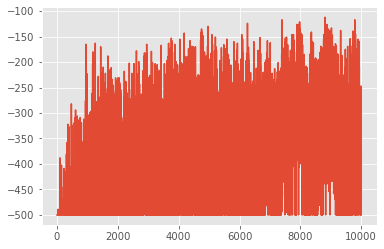

In [23]:
plt.plot(range(10000),scores)

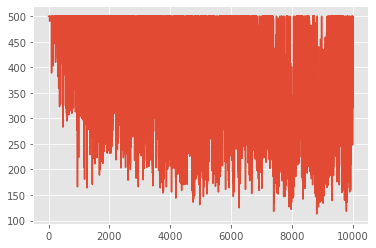

In [24]:
plt.plot(range(10000),steps)

In [25]:
a=list(np.where(np.array(steps)<500))
len(a[0])

6688

In [ ]:
import pandas as pd

In [ ]:
rolling_mean = pd.Series(scores).rolling(100).mean()
plt.plot(range(10000),rolling_mean)

In [27]:
import pandas as pd

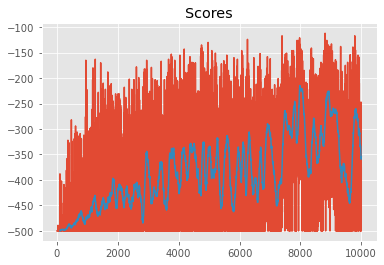

In [28]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)

In [ ]:
steps